In [1]:
pip install biosppy nolds scikit-learn peakutils

Note: you may need to restart the kernel to use updated packages.


In [3]:
import wfdb
import numpy as np
import pandas as pd
import glob
import os
from wfdb import rdrecord
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from scipy import signal, fft
from scipy.signal import spectrogram
from biosppy.signals.ecg import christov_segmenter, hamilton_segmenter
from nolds import sampen
from sklearn.impute import SimpleImputer

2025-03-27 10:48:24.410607: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 10:48:24.421233: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 10:48:24.523157: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 10:48:24.611128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743072504.691153     315 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743072504.71

## code15 데이터 불러오기 (메타데이터 모두 포함)

In [7]:
import os

# 데이터 폴더 경로
data_folder = '/workspace/data/physionet2025/code15_output/exams_part0/'

# .dat 파일만 골라서 개수 세기
dat_files = [f for f in os.listdir(data_folder) if f.endswith('.dat')]
num_records = len(dat_files)

print(f"총 ECG 데이터 개수: {num_records}")

총 ECG 데이터 개수: 19901


In [12]:
import wfdb
import os
import pandas as pd
from tqdm import tqdm

# 데이터 폴더
data_path = "/workspace/data/physionet2025/code15_output/exams_part0"

# record 이름 추출 (.dat 파일 기준)
records = [f.replace('.dat', '') for f in os.listdir(data_path) if f.endswith('.dat')]

# 결과 저장 리스트
records_data = []

# 반복적으로 record 불러오기
for record_name in tqdm(records, desc="🔄 레코드 로딩 중"):
    try:
        record_path = os.path.join(data_path, record_name)
        record = wfdb.rdrecord(record_path)

        # 코멘트에서 메타데이터 추출
        age, sex, chagas = None, None, None
        for comment in record.comments:
            if "Age:" in comment:
                age = int(comment.split("Age:")[1].strip())
            elif "Sex:" in comment:
                sex = comment.split("Sex:")[1].strip()
            elif "Chagas label:" in comment:
                chagas = comment.split("Chagas label:")[1].strip()

        
        # 저장
        records_data.append({
            'record_name': record_name,
            'p_signal': record.p_signal,   # numpy array
            'Age': age,
            'Sex': sex,
            'Chagas_label': chagas
        })
    except Exception as e:
        print(f"⚠️ {record_name} 불러오기 실패: {e}")

# ✅ DataFrame 생성
df_code15 = pd.DataFrame(records_data)

# ✅ Chagas_label을 Boolean or 0/1로 바꾸고 싶다면:
df_code15['Chagas_label'] = df_code15['Chagas_label'].map({'True': 1, 'False': 0})

# 결과 확인
print(f"🔍 총 {len(df_code15)}개 record 로딩 완료!")
df_code15.head()

🔄 레코드 로딩 중: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19901/19901 [00:42<00:00, 466.92it/s]


🔍 총 19901개 record 로딩 완료!


,record_name,p_signal,Age,Sex,Chagas_label
0,1398216,"[[-1.601, 1.052, 2.652, 0.274, -2.127, 1.852, ...",35,Female,0
1,620215,"[[0.518, 1.326, 0.808, -0.922, -0.145, 1.067, ...",19,Female,0
2,712938,"[[1.837, 1.573, -0.264, -1.7, 1.055, 0.655, -1...",59,Female,0
3,1504935,"[[-1.951, -4.063, -2.111, 3.011, 0.084, -3.087...",60,Female,0
4,1229800,"[[0.195, -0.205, -0.401, 0.01, 0.303, -0.303, ...",58,Female,0


In [14]:
import pandas as pd

# ✅ 메타데이터 파일 불러오기
exams_path = "/workspace/data/physionet2025/code15_input/exams.csv"
df_exams = pd.read_csv(exams_path)

# ✅ df_code15에 exam_id 컬럼이 있다면 merge
# 혹시 없다면 record_name에서 추출
if 'exam_id' not in df_code15.columns:
    # record_name에서 숫자 부분 추출
    df_code15['exam_id'] = df_code15['record_name'].str.extract(r'(\d+)').astype(int)

# ✅ Merge: exam_id 기준으로 left join
df_code15_merged = pd.merge(df_code15, df_exams, on='exam_id', how='left')

# ✅ 결과 확인
print(f"🔍 병합된 데이터 shape: {df_code15_merged.shape}")
df_code15_merged.head()

🔍 병합된 데이터 shape: (19901, 20)


,record_name,p_signal,Age,Sex,Chagas_label,exam_id,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file
0,1398216,"[[-1.601, 1.052, 2.652, 0.274, -2.127, 1.852, ...",35,Female,0,1398216,35,False,50.454483,False,False,False,False,False,False,1769355,NaN,NaN,False,exams_part0.hdf5
1,620215,"[[0.518, 1.326, 0.808, -0.922, -0.145, 1.067, ...",19,Female,0,620215,19,False,28.217638,False,False,False,False,False,False,960621,False,3.246573,True,exams_part0.hdf5
2,712938,"[[1.837, 1.573, -0.264, -1.7, 1.055, 0.655, -1...",59,Female,0,712938,59,False,67.447525,False,False,False,False,False,False,168056,NaN,NaN,False,exams_part0.hdf5
3,1504935,"[[-1.951, -4.063, -2.111, 3.011, 0.084, -3.087...",60,Female,0,1504935,60,False,64.676575,False,False,False,False,False,False,156537,NaN,NaN,True,exams_part0.hdf5
4,1229800,"[[0.195, -0.205, -0.401, 0.01, 0.303, -0.303, ...",58,Female,0,1229800,58,False,66.523140,False,False,False,False,False,False,506401,NaN,NaN,False,exams_part0.hdf5


In [21]:
# 복사해서 원본 보존
df_cleaned = df_code15_merged.copy()

# 제거할 컬럼 목록
columns_to_drop = ['trace_file', 'record_name', 'exam_id', 'patient_id', 'death', 'timey', 'age', 'Sex']

# 제거 수행
df_code15 = df_cleaned.drop(columns=columns_to_drop, errors='ignore')

# 결과 확인
print(f"🧹 정리된 컬럼 수: {df_code15.shape[1]}")

🧹 정리된 컬럼 수: 12


In [22]:
df_code15

,p_signal,Age,Chagas_label,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,normal_ecg
0,"[[-1.601, 1.052, 2.652, 0.274, -2.127, 1.852, ...",35,0,False,50.454483,False,False,False,False,False,False,False
1,"[[0.518, 1.326, 0.808, -0.922, -0.145, 1.067, ...",19,0,False,28.217638,False,False,False,False,False,False,True
2,"[[1.837, 1.573, -0.264, -1.7, 1.055, 0.655, -1...",59,0,False,67.447525,False,False,False,False,False,False,False
3,"[[-1.951, -4.063, -2.111, 3.011, 0.084, -3.087...",60,0,False,64.676575,False,False,False,False,False,False,True
4,"[[0.195, -0.205, -0.401, 0.01, 0.303, -0.303, ...",58,0,False,66.523140,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
19896,"[[-0.107, -0.029, 0.078, 0.078, -0.088, 0.029,...",43,0,False,65.805900,False,False,False,False,False,False,False
19897,"[[-0.205, -0.537, -0.332, 0.381, 0.068, -0.43,...",27,0,False,23.983795,False,False,False,False,False,False,False
19898,"[[0.595, -0.976, -1.57, 0.191, 1.082, -1.273, ...",18,0,True,39.463303,False,False,False,False,False,False,False
19899,"[[-0.029, -0.049, -0.02, 0.049, 0.0, -0.029, 0...",83,0,False,78.901230,False,False,False,False,False,False,False


### 간단히 로지스틱 (RBBB 등 기타 심장질환)

In [23]:
import statsmodels.api as sm

# 설명 변수와 타겟 변수 지정
X = df_code15[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF', 'normal_ecg']].astype(int)
y = df_code15['Chagas_label'].astype(int)

# 상수항 추가
X = sm.add_constant(X)

# 로지스틱 회귀 모델 적합
model = sm.Logit(y, X)
result = model.fit()

# 결과 요약 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.091173
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           Chagas_label   No. Observations:                19901
Model:                          Logit   Df Residuals:                    19893
Method:                           MLE   Df Model:                            7
Date:                Thu, 27 Mar 2025   Pseudo R-squ.:                 0.07735
Time:                        11:40:15   Log-Likelihood:                -1814.4
converged:                       True   LL-Null:                       -1966.5
Covariance Type:            nonrobust   LLR p-value:                 7.574e-62
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8109      0.067    -57.097      0.000      -3.942      -3.680
1dAVb          0.2514      0.

RBBB, LBBB, AF, normal_ecg 를 변수로 남기기

In [24]:
# 제거할 컬럼 목록
columns_to_drop = ['1dAVb', 'SB', 'ST']

# 제거 수행
df_code15 = df_code15.drop(columns=columns_to_drop, errors='ignore')

# 결과 확인
df_code15.head()

,p_signal,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg
0,"[[-1.601, 1.052, 2.652, 0.274, -2.127, 1.852, ...",35,0,False,50.454483,False,False,False,False
1,"[[0.518, 1.326, 0.808, -0.922, -0.145, 1.067, ...",19,0,False,28.217638,False,False,False,True
2,"[[1.837, 1.573, -0.264, -1.7, 1.055, 0.655, -1...",59,0,False,67.447525,False,False,False,False
3,"[[-1.951, -4.063, -2.111, 3.011, 0.084, -3.087...",60,0,False,64.676575,False,False,False,True
4,"[[0.195, -0.205, -0.401, 0.01, 0.303, -0.303, ...",58,0,False,66.523140,False,False,False,False


In [25]:
# 전체 bool 타입 컬럼을 int(0/1)로 변환
bool_cols = df_code15.select_dtypes(include='bool').columns
df_code15[bool_cols] = df_code15[bool_cols].astype(int)

df_code15.head()

,p_signal,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg
0,"[[-1.601, 1.052, 2.652, 0.274, -2.127, 1.852, ...",35,0,0,50.454483,0,0,0,0
1,"[[0.518, 1.326, 0.808, -0.922, -0.145, 1.067, ...",19,0,0,28.217638,0,0,0,1
2,"[[1.837, 1.573, -0.264, -1.7, 1.055, 0.655, -1...",59,0,0,67.447525,0,0,0,0
3,"[[-1.951, -4.063, -2.111, 3.011, 0.084, -3.087...",60,0,0,64.676575,0,0,0,1
4,"[[0.195, -0.205, -0.401, 0.01, 0.303, -0.303, ...",58,0,0,66.523140,0,0,0,0


In [27]:
print(df_code15.RBBB.value_counts())
print(df_code15.LBBB.value_counts())
print(df_code15.AF.value_counts())
print(df_code15.normal_ecg.value_counts())

RBBB
0    19376
1      525
Name: count, dtype: int64
LBBB
0    19565
1      336
Name: count, dtype: int64
AF
0    19457
1      444
Name: count, dtype: int64
normal_ecg
0    12207
1     7694
Name: count, dtype: int64


In [28]:
df_code15.to_pickle("code15_exam0_cleaned.pkl")

# Feature Engineering

In [30]:
import os
import wfdb
import pandas as pd
from tqdm import tqdm

def process_code15_dataset(ecg_folder, exams_csv_path, output_pkl_path):
    """
    Code15 ECG 데이터 처리 함수
    - .dat & .hea 로드
    - exams.csv 메타데이터 merge
    - 필요한 컬럼만 추출
    - True/False → 1/0 변환
    - .pkl 파일로 저장
    """

    # 1. .dat 파일 기준 record 목록 추출
    record_names = [f.replace('.dat', '') for f in os.listdir(ecg_folder) if f.endswith('.dat')]

    records = []
    for record_name in tqdm(record_names, desc="🔄 ECG 로딩 중"):
        try:
            record_path = os.path.join(ecg_folder, record_name)
            record = wfdb.rdrecord(record_path)
            exam_id = int(record_name.split("_")[0]) if "_" in record_name else int(record_name)

            # .hea 코멘트에서 나이, 성별, 라벨 추출
            age, sex, chagas = None, None, None
            for c in record.comments:
                if "Age:" in c:
                    age = int(c.split("Age:")[1].strip())
                elif "Sex:" in c:
                    sex = c.split("Sex:")[1].strip()
                elif "Chagas label:" in c:
                    chagas = c.split("Chagas label:")[1].strip()

            records.append({
                'record_name': record_name,
                'exam_id': exam_id,
                'p_signal': record.p_signal,
                'Age': age,
                'Sex': sex,
                'Chagas_label': chagas
            })

        except Exception as e:
            print(f"⚠️ {record_name} 로드 실패: {e}")

    # 2. DataFrame 생성
    df = pd.DataFrame(records)

    # 3. Chagas_label 변환 (문자 → 0/1)
    df['Chagas_label'] = df['Chagas_label'].map({'True': 1, 'False': 0})

    # 4. exams.csv 불러오기 및 merge
    df_exams = pd.read_csv(exams_csv_path)
    df = df.merge(df_exams, on='exam_id', how='left')

    # 5. 필요한 컬럼만 추출
    cols_to_keep = ['exam_id', 'p_signal', 'Age', 'Chagas_label',
                    'is_male', 'nn_predicted_age', 'RBBB', 'LBBB', 'AF', 'normal_ecg']
    df = df[cols_to_keep]

    # 6. True/False → 1/0
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)

    # 7. 저장
    df.to_pickle(output_pkl_path)
    print(f"✅ 저장 완료: {output_pkl_path} (총 {len(df)}개 샘플)")

    return df

In [31]:
# Part0
df_part0 = process_code15_dataset(
    ecg_folder="/workspace/data/physionet2025/code15_output/exams_part0",
    exams_csv_path="/workspace/data/physionet2025/code15_input/exams.csv",
    output_pkl_path="/workspace/my_data/code15_part0.pkl"
)

🔄 ECG 로딩 중: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19901/19901 [00:42<00:00, 467.80it/s]


✅ 저장 완료: /workspace/my_data/code15_part0.pkl (총 19901개 샘플)


In [32]:
df_part0

,exam_id,p_signal,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg
0,1398216,"[[-1.601, 1.052, 2.652, 0.274, -2.127, 1.852, ...",35,0,0,50.454483,0,0,0,0
1,620215,"[[0.518, 1.326, 0.808, -0.922, -0.145, 1.067, ...",19,0,0,28.217638,0,0,0,1
2,712938,"[[1.837, 1.573, -0.264, -1.7, 1.055, 0.655, -1...",59,0,0,67.447525,0,0,0,0
3,1504935,"[[-1.951, -4.063, -2.111, 3.011, 0.084, -3.087...",60,0,0,64.676575,0,0,0,1
4,1229800,"[[0.195, -0.205, -0.401, 0.01, 0.303, -0.303, ...",58,0,0,66.523140,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
19896,3002545,"[[-0.107, -0.029, 0.078, 0.078, -0.088, 0.029,...",43,0,0,65.805900,0,0,0,0
19897,771599,"[[-0.205, -0.537, -0.332, 0.381, 0.068, -0.43,...",27,0,0,23.983795,0,0,0,0
19898,765682,"[[0.595, -0.976, -1.57, 0.191, 1.082, -1.273, ...",18,0,1,39.463303,0,0,0,0
19899,802906,"[[-0.029, -0.049, -0.02, 0.049, 0.0, -0.029, 0...",83,0,0,78.901230,0,0,0,0


In [34]:
# Part1
df_part1 = process_code15_dataset(
    ecg_folder="/workspace/data/physionet2025/code15_output/exams_part1",
    exams_csv_path="/workspace/data/physionet2025/code15_input/exams.csv",
    output_pkl_path="/workspace/my_data/code15_part1.pkl"
)

🔄 ECG 로딩 중: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19897/19897 [00:42<00:00, 463.79it/s]


✅ 저장 완료: /workspace/my_data/code15_part1.pkl (총 19897개 샘플)


In [35]:
# 위아래로 이어 붙이기 (row 방향 concat)
df = pd.concat([df_part0, df_part1], axis=0).reset_index(drop=True)

# 결과 확인
print(f"✅ 전체 샘플 수: {len(df)}")
df

✅ 전체 샘플 수: 39798


,exam_id,p_signal,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg
0,1398216,"[[-1.601, 1.052, 2.652, 0.274, -2.127, 1.852, ...",35,0,0,50.454483,0,0,0,0
1,620215,"[[0.518, 1.326, 0.808, -0.922, -0.145, 1.067, ...",19,0,0,28.217638,0,0,0,1
2,712938,"[[1.837, 1.573, -0.264, -1.7, 1.055, 0.655, -1...",59,0,0,67.447525,0,0,0,0
3,1504935,"[[-1.951, -4.063, -2.111, 3.011, 0.084, -3.087...",60,0,0,64.676575,0,0,0,1
4,1229800,"[[0.195, -0.205, -0.401, 0.01, 0.303, -0.303, ...",58,0,0,66.523140,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
39793,1549519,"[[-0.401, 1.016, 1.417, -0.303, -0.909, 1.221,...",40,0,1,66.570370,0,0,0,1
39794,4208809,"[[-0.186, -0.225, -0.039, 0.215, -0.068, -0.12...",36,0,1,31.170006,0,0,0,0
39795,475767,"[[-1.448, -1.547, -0.099, 1.502, -0.671, -0.82...",61,0,0,61.709570,0,0,0,1
39796,1524075,"[[1.387, 0.633, -0.755, -1.006, 1.067, -0.061,...",40,0,0,57.973840,0,0,0,1


### **신호 전처리**
ECG 신호는 노이즈(근육 활동, 전극 간섭, 기저선 변동)가 포함될 수 있음 \
밴드패스 필터(0.1-45Hz)를 적용하여 의미 있는 심장 신호만 남기기. 

---

### **R-peak 검출**
Christov 알고리즘을 이용한 검출

---

### **QRS 복합체 분석 (QRS Width Calculation)**
Hamilton 알고리즘을 이용해 QRS 시작점 & 종료점을 찾고 QRS 폭(시간 간격, QRS duration)을 계산 \
QRS 폭이 길어지면 심장 전도 장애(전도 차단) 가능성이 높음 \
Chagas병 환자는 QRS 폭이 비정상적으로 증가하는 경우가 많음!

---

### **QT 간격 분석** 
R 피크부터 T파 종료점까지의 간격(QT Interval)을 계산 \
QT 간격이 길어지면 심실 부정맥 가능성이 증가! \
선행 연구들에서 Chagas병 환자는 QT 간격이 연장되는 경향이 있음이 확인됨 
- 결과 해석 \
-- QTd(QT dispersion) ≥65ms인 경우 사망 위험 2.18배 증가 (95% CI 1.35-3.53) \
-- QTc ≥465ms에서 3.2배 높은 심혈관 사망률 (95% CI 1.8-5.7)

---

### **주파수 분석 (frequency analysis)**
FFT 변환 수행 -> 주파수별 에너지를 분석함.

**LF, HF 분석** 
LF/HF 비율을 계산하여 자율신경계 균형 분석\
LF 파워 증가 → 교감신경 활성화 (스트레스 반응) \
HF 파워 증가 → 부교감신경 활성화 (이완 반응)\
LF/HF 비율 증가 → 교감신경 과활성 (부정맥, 고혈압, *Chagas병 특징*)

---

### **샘플 엔트로피(Sample Entropy) 분석** 
ECG 신호의 복잡성을 측정 (Chagas병 환자는 심장 박동이 더 예측 가능하고, 복잡성이 감소하는 경향)\
엔트로피 값이 작을수록 심장이 규칙적으로 뛰며, 복잡하지 않은 것 \
cf.참고 지표: 정상인: 1.2 ~ 1.8 , Chagas병 환자: 0.6 ~ 1.0

---

### **심박 변이(HRV) 분석**
**Poincare feature 분석** 
SD1 (Short-Term Variability) → 단기 변동성 / SD2 (Long-Term Variability) → 장기 변동성 \
SD1/SD2 비율 → 자율신경계 균형 분석\
- 결과 해석: \
-- SD1 감소 → Chagas병 환자는 심박수의 단기 변동이 감소\
-- SD2 감소 → 심장 리듬이 전반적으로 일정해짐\
-- SD1/SD2 ratio 감소 → 자율신경계 균형이 무너진 상태

**RMSSD (Root Mean Square of Successive Differences) 분석**
선행 연구들에서  Chagas 환자의 HRV 저하 확인\
RMSSD ≤25ms에서 사망 위험 1.26배 증가 (95% CI 1.14-1.40)\
자율신경계 불균형(교감항진/부교감저하) 반영

**SDNN (Standard Deviation of NN intervals) 분석**\
정상적인 심장 박동(R-R 간격) 간격의 표준편차\
Chagas병 환자는 SDNN이 낮은 경향이 있음
- 결과 해석 \
SDNN이 크면? → 심박 변이도가 크다 (정상적인 자율신경 조절)
SDNN이 작으면? → 심박 변이도가 낮다 (자율신경 조절 기능 저하, Chagas병 가능성)

---

### **T파 분석 (T-wave Analysis)**
T파의 크기(T-wave Amplitude)와 기울기(T-wave Slope)를 분석 \
Chagas병 환자는 비정상적인 T파 변형이 자주 나타남\
정상적인 T파 진폭의 범위는 리드에 따라 다르지만, 일반적으로 아래와 같음. 
- 리드 I, II	: 0.1 ~ 0.5 mV
- 리드 V2 ~ V6 :	0.2 ~ 1.0 mV
- 리드 aVR :	T파가 음성(negative)일 가능성이 있음
- 결과 해석 \
T파 진폭이 너무 낮거나 높으면? → 심실의 재분극(Repolarization) 이상 가능성
T파 기울기가 너무 가파르면? → QT 간격 연장, 부정맥 가능성 증가
Chagas병 환자는 T파가 변형되거나 진폭이 낮은 경향이 있음!

---



### 함수 정의

In [39]:
import numpy as np
import pandas as pd
import pywt
import wfdb
from wfdb.processing import gqrs_detect
from scipy.signal import butter, filtfilt, welch, find_peaks
from scipy.stats import entropy
from multiprocessing import Pool, cpu_count
from sklearn.impute import SimpleImputer
import time
import scipy.ndimage

In [77]:
# ✅ 웨이블릿 기반 노이즈 제거
def wavelet_denoise(signal, wavelet='db6', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

# ✅ 형태학적 필터를 이용한 기저선 제거
def oc_co_filter(signal, fs, k_factor):
    k_size = int(np.round(k_factor * fs))
    struct_elem = np.ones(k_size)
    opened = scipy.ndimage.grey_opening(signal, structure=struct_elem)
    closed = scipy.ndimage.grey_closing(opened, structure=struct_elem)
    return scipy.ndimage.grey_opening(closed, structure=struct_elem)

# ✅ 전처리 함수 (선택적으로 밴드패스 필터 추가)
def preprocess_ecg(signal_data, fs=400, use_bandpass=False):
    if signal_data.ndim == 2:
        cleaned = np.zeros_like(signal_data)
        for i in range(signal_data.shape[1]):
            x = signal_data[:, i]
            if use_bandpass:
                nyq = 0.5 * fs
                b, a = butter(4, [0.1 / nyq, 45 / nyq], btype='band')
                x = filtfilt(b, a, x)
            denoised = wavelet_denoise(x)
            baseline = oc_co_filter(denoised, fs, 0.27)
            cleaned[:, i] = denoised - baseline
        return cleaned
    else:
        x = signal_data
        if use_bandpass:
            nyq = 0.5 * fs
            b, a = butter(4, [0.1 / nyq, 45 / nyq], btype='band')
            x = filtfilt(b, a, x)
        denoised = wavelet_denoise(x)
        baseline = oc_co_filter(denoised, fs, 0.27)
        return denoised - baseline

# ✅ R 피크 검출 (gqrs_detect 필요)
def detect_r_peaks(ecg_signal, fs=400):
    from wfdb.processing import gqrs_detect
    r_peaks = gqrs_detect(sig=ecg_signal, fs=fs)
    return r_peaks if len(r_peaks) > 1 else np.array([])

# ✅ QRS 폭 및 QT 간격 계산
def analyze_qrs_qt(ecg_signal, r_peaks, fs=400):
    if len(r_peaks) < 2:
        return {'qrs_width': np.nan, 'qt_interval': np.nan}
    
    qrs_widths = np.diff(r_peaks) / fs
    qt_intervals = []

    for r in r_peaks:
        if r + int(0.5 * fs) < len(ecg_signal):
            segment = ecg_signal[r:r + int(0.5 * fs)]
            peaks, _ = find_peaks(-segment)
            if len(peaks) > 0:
                qt_intervals.append((r + peaks[-1] - r) / fs)

    return {
        'qrs_width': np.nanmean(qrs_widths),
        'qt_interval': np.nanmean(qt_intervals) if qt_intervals else np.nan
    }

# ✅ HRV 분석
def hrv_analysis(r_peaks, fs=400):
    if len(r_peaks) < 2:
        return {'rmssd': np.nan, 'sdnn': np.nan, 'sd1': np.nan, 
                'sd2': np.nan, 'sd_ratio': np.nan}

    rr_intervals = np.diff(r_peaks) / fs
    diff_rr = np.diff(rr_intervals)
    
    return {
        'rmssd': np.sqrt(np.mean(diff_rr**2)),
        'sdnn': np.std(rr_intervals),
        'sd1': np.std(diff_rr) / np.sqrt(2),
        'sd2': np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2),
        'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / 
                    (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2))
    }

# ✅ 주파수 분석
def frequency_analysis(ecg_signal, fs=400):
    freqs, power = welch(ecg_signal, fs=fs, nperseg=256)
    bands = {'ulf': (0.003, 0.04), 'vlf': (0.04, 0.15), 'lf': (0.04, 0.15), 'hf': (0.15, 0.4)}
    total_energy = np.sum(power)
    band_energy = {band: np.sum(power[(freqs >= low) & (freqs < high)]) for band, (low, high) in bands.items()}
    return {k: v / total_energy if total_energy > 0 else 0 for k, v in band_energy.items()}

# ✅ 웨이블릿 변환 특징 추출
def extract_wavelet_features(ecg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    features = {}
    total_energy = sum(np.sum(np.square(c)) for c in coeffs)
    entropies = [entropy(np.abs(c) / np.sum(np.abs(c)), base=2) if np.sum(np.abs(c)) > 0 else 0 for c in coeffs]

    for i, c in enumerate(coeffs):
        abs_c = np.abs(c)
        features[f'wavelet_L{i}_mean'] = np.mean(abs_c)
        features[f'wavelet_L{i}_std'] = np.std(c)
        features[f'wavelet_L{i}_energy'] = np.sum(np.square(c))
        features[f'wavelet_L{i}_energy_ratio'] = np.sum(np.square(c)) / total_energy if total_energy > 0 else 0

    features['wavelet_entropy'] = np.mean(entropies)
    return features

# ✅ 전체 ECG 특징 추출 함수
def extract_features(ecg_signal, fs=400):
    """하나의 ECG 리드에서 특징 추출"""
    filtered = preprocess_ecg(ecg_signal, fs)
    r_peaks = detect_r_peaks(filtered, fs)

    return {
        **analyze_qrs_qt(filtered, r_peaks, fs),
        **hrv_analysis(r_peaks, fs),
        **frequency_analysis(filtered, fs),
        **extract_wavelet_features(filtered)
    }

def process_with_progress(df, num_samples=None, fs=400, lead_index=0, use_bandpass=False):
    """
    p_signal에서 ECG 특징을 추출하고 메타데이터와 함께 반환
    
    Parameters:
    - df: 원본 DataFrame (p_signal 포함)
    - num_samples: 처리할 샘플 수 (기본: 전체)
    - fs: 샘플링 주파수
    - lead_index: 사용할 리드 인덱스 (default: 1번 리드)
    - use_bandpass: 밴드패스 필터를 추가 적용할지 여부

    Returns:
    - 특징 + 메타데이터를 포함한 DataFrame
    """
    start_time = time.time()
    if num_samples is None:
        df_sample = df.copy().reset_index(drop=True)
    else:
        df_sample = df.sample(n=num_samples, random_state=42).reset_index(drop=True)

    all_rows = []

    for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="🔹 특징 추출 중", dynamic_ncols=True):
        try:
            ecg_signal = row["p_signal"][:, lead_index]  # 원하는 리드 선택
            features = extract_features(ecg_signal, fs=fs)

            # ✅ p_signal 제외한 나머지 메타데이터 붙이기
            metadata = row.drop("p_signal").to_dict()
            merged = {**features, **metadata}
            all_rows.append(merged)

        except Exception as e:
            print(f"⚠️ 오류 발생: {e} (샘플 {idx} 건너뜀)")
            continue

    df_features = pd.DataFrame(all_rows)

    if df_features.empty:
        print("❌ 모든 샘플에서 특징 추출 실패.")
        return None

    # Inf → NaN 처리
    df_features.replace([np.inf, -np.inf], np.nan, inplace=True)

    # NaN이 40% 이상인 컬럼 제거
    df_features = df_features.dropna(axis=1, thresh=0.6 * len(df_features))

    end_time = time.time()
    print(f"\n✅ 총 {len(df_features)}개 샘플 특징 추출 완료! (소요시간: {end_time - start_time:.2f}초)")

    return df_features


### code15 데이터 처리

#### 피처 추출

In [38]:
# ✅ 실행
df1 = process_with_progress(df)

# ✅ 변환된 데이터 확인
df1

/tmp/ipykernel_315/3855303139.py:72: RuntimeWarning: invalid value encountered in scalar divide                                                                                    | 22/39798 [00:00<25:01, 26.49it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2))
/tmp/ipykernel_315/3855303139.py:72: RuntimeWarning: invalid value encountered in scalar divide                                                                                    | 79/39798 [00:02<21:28, 30.84it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2))
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.                                                                       | 97/39798 [00:03<18:28, 35.80it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invali

✅ 총 39798개 샘플 특징 추출 완료 (소요시간: 1034.18초)


,qrs_width,qt_interval,rmssd,sdnn,sd1,sd2,sd_ratio,ulf,vlf,lf,...,wavelet_entropy,exam_id,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg
0,0.960625,0.449167,0.029201,0.018781,0.020634,0.017210,1.198980,0.0,0.0,0.0,...,7.746864,525202,32,0,0,43.944702,0,0,0,1
1,0.750000,0.468750,0.013463,0.011260,0.009446,0.012569,0.751555,0.0,0.0,0.0,...,7.313234,3188206,32,0,0,48.128290,0,0,0,0
2,0.881667,0.470357,0.030741,0.029392,0.020988,0.033474,0.626999,0.0,0.0,0.0,...,7.038546,592156,53,0,0,40.106136,0,0,0,1
3,0.910000,0.482500,0.035816,0.020555,0.024443,0.013828,1.767659,0.0,0.0,0.0,...,7.107475,1672120,47,0,0,43.059250,0,0,0,1
4,0.846786,0.480625,0.026693,0.015625,0.018643,0.012652,1.473556,0.0,0.0,0.0,...,7.027753,1574281,23,0,0,22.791504,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39793,0.920000,0.480714,0.033335,0.017440,0.023569,0.012450,1.893111,0.0,0.0,0.0,...,6.915964,3800279,50,0,0,43.053734,0,0,0,0
39794,0.998500,0.475833,0.012624,0.008000,0.008750,0.004760,1.838290,0.0,0.0,0.0,...,7.537773,4269299,45,0,0,47.077026,0,0,0,0
39795,0.605556,0.456500,0.014142,0.008642,0.010000,0.007706,1.297771,0.0,0.0,0.0,...,8.084615,23974,72,0,0,81.432350,0,0,0,1
39796,0.807857,0.479375,0.026280,0.015892,0.018392,0.013972,1.316347,0.0,0.0,0.0,...,7.940004,1551771,67,0,1,66.443580,0,0,0,1


In [41]:
# ✅ 필요 시 직접 저장
df1.to_pickle("ECG_code15_0+1_lead2.pkl")
print("🔹 데이터 저장 완료: ECG_3dataset_37613_lead2.pkl")

🔹 데이터 저장 완료: ECG_3dataset_37613_lead2.pkl


In [19]:
# path = "/workspace/ECG_3dataset_37613.pkl"

# with open(path, "rb") as f:
#     df = pickle.load(f)
# print(type(df))  

#### 함수 실행

### 모델링

In [39]:
# pip install --upgrade xgboost

In [129]:
# pip install imbalanced-learn

In [44]:
import numpy as np
import pandas as pd
import time
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, callback

# X, y 나누기
def preprocess_dataframe(df):
    """데이터프레임에서 NaN 처리 및 feature, target 분리"""
    df = df.dropna(axis=1, thresh=0.5 * len(df))  # NaN이 50% 이상인 컬럼 제거

    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(df.drop(columns=["Chagas_label"]))
    y = df["Chagas_label"].values  # 타겟 변수 분리

    return X, y

# 데이터 스플릿 (8:2)
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

# CatBoost parameter 최적화 함수
def objective_catboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

    
# ✅ Catboost 학습
def train_catboost(X_train, y_train, X_test, y_test, **params):
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    return model


# ✅ 모델 평가
def evaluate_model(model, X_test, y_test, model_name):
    """Confusion Matrix 및 성능 지표 출력"""
    y_pred = model.predict(X_test)
    
    print(f"\n✅ {model_name} 모델 평가")
    print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
    print("🔹 F1 Score:", f1_score(y_test, y_pred))
    print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

    # ✅ Confusion Matrix 시각화
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    
# ✅ Feature Importance 시각화
def plot_feature_importance(model, feature_names):
    """Feature Importance 시각화"""
    feature_importances = model.get_feature_importance()
    sorted_idx = np.argsort(feature_importances)[::-1]  # 중요도가 높은 순 정렬

    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importances[sorted_idx[:10]], y=np.array(feature_names)[sorted_idx[:10]], palette="viridis")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.title("Top 10 Feature Importances")
    plt.show()

In [66]:
df1

,qrs_width,qt_interval,rmssd,sdnn,sd1,sd2,sd_ratio,ulf,vlf,lf,...,wavelet_entropy,exam_id,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg
0,0.960625,0.449167,0.029201,0.018781,0.020634,0.017210,1.198980,0.0,0.0,0.0,...,7.746864,525202,32,0,0,43.944702,0,0,0,1
1,0.750000,0.468750,0.013463,0.011260,0.009446,0.012569,0.751555,0.0,0.0,0.0,...,7.313234,3188206,32,0,0,48.128290,0,0,0,0
2,0.881667,0.470357,0.030741,0.029392,0.020988,0.033474,0.626999,0.0,0.0,0.0,...,7.038546,592156,53,0,0,40.106136,0,0,0,1
3,0.910000,0.482500,0.035816,0.020555,0.024443,0.013828,1.767659,0.0,0.0,0.0,...,7.107475,1672120,47,0,0,43.059250,0,0,0,1
4,0.846786,0.480625,0.026693,0.015625,0.018643,0.012652,1.473556,0.0,0.0,0.0,...,7.027753,1574281,23,0,0,22.791504,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39793,0.920000,0.480714,0.033335,0.017440,0.023569,0.012450,1.893111,0.0,0.0,0.0,...,6.915964,3800279,50,0,0,43.053734,0,0,0,0
39794,0.998500,0.475833,0.012624,0.008000,0.008750,0.004760,1.838290,0.0,0.0,0.0,...,7.537773,4269299,45,0,0,47.077026,0,0,0,0
39795,0.605556,0.456500,0.014142,0.008642,0.010000,0.007706,1.297771,0.0,0.0,0.0,...,8.084615,23974,72,0,0,81.432350,0,0,0,1
39796,0.807857,0.479375,0.026280,0.015892,0.018392,0.013972,1.316347,0.0,0.0,0.0,...,7.940004,1551771,67,0,1,66.443580,0,0,0,1


In [68]:
# 함수 실행
df1.drop(columns=['exam_id'], inplace=True)
X, y = preprocess_dataframe(df1)  # 데이터 전처리
X_train, X_test, y_train, y_test = split_data(X, y)  # 데이터 스플릿

In [69]:
# 현재 클래스 분포 확인
print("🔍 원본 클래스 분포:")
print(pd.Series(y_train).value_counts())

🔍 원본 클래스 분포:
0    33132
1      696
Name: count, dtype: int64


In [70]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling 적용
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Catboost

In [71]:
from collections import Counter

# 클래스 분포 확인
counter = Counter(y_train)
print(counter)  # 예: Counter({0: 18000, 1: 2000})

# 가중치 계산 (비율 반대로 주기)
total = sum(counter.values())
class_weights = {
    0: total / (2 * counter[0]),
    1: total / (2 * counter[1])
}
print("Class weights:", class_weights)

Counter({0: 33132, 1: 696})
Class weights: {0: 0.5105034407823252, 1: 24.301724137931036}


In [72]:
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_catboost, n_trials=10)

best_params_cat = study_cat.best_params
print("최적 CatBoost 하이퍼파라미터:", best_params_cat)

[I 2025-03-27 13:17:39,441] A new study created in memory with name: no-name-7204c076-5f87-4a0d-994a-aea859fa7ffd
/tmp/ipykernel_315/935703522.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_315/935703522.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
/tmp/ipykernel_315/935703522.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_u

최적 CatBoost 하이퍼파라미터: {'n_estimators': 1519, 'depth': 7, 'learning_rate': 0.24749288880313755, 'l2_leaf_reg': 0.02011804411944159, 'bagging_temperature': 0.5981838107232764}


In [73]:
# 최적 CatBoost 하이퍼파라미터: {'n_estimators': 1519, 'depth': 7, 'learning_rate': 0.24749288880313755, 'l2_leaf_reg': 0.02011804411944159, 'bagging_temperature': 0.5981838107232764}

catboost_model = CatBoostClassifier(
                    **best_params_cat,
                    # class_weights=class_weights,  # ✅ 가중치 추가!
                    verbose=0)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

# ✅ 3. CatBoost 모델 평가
y_pred_cat = catboost_model.predict(X_test)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)

print(f"CatBoost Accuracy: {accuracy_cat:.4f}")
print(f"CatBoost F1 Score: {f1_cat:.4f}")

# CatBoost Accuracy: 0.9789
# CatBoost F1 Score: 0.0000

## 가중치 줄 경우
# CatBoost Accuracy: 0.7432
# CatBoost F1 Score: 0.1113

CatBoost Accuracy: 0.9787
CatBoost F1 Score: 0.0451


/tmp/ipykernel_315/270205707.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx[:10]], y=np.array(feature_names)[sorted_idx[:10]], palette="viridis")


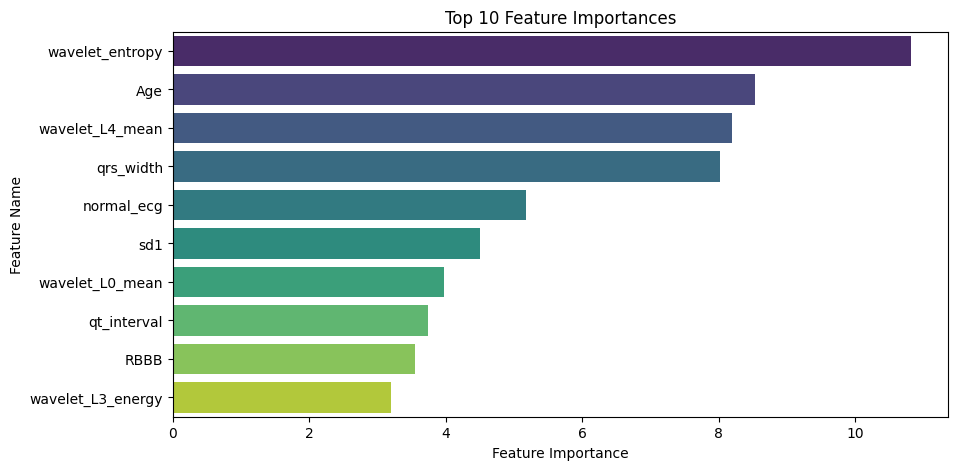

In [74]:
# 예시
feature_names = df1.drop(columns=["Chagas_label"]).columns.tolist()
plot_feature_importance(catboost_model, feature_names)

In [75]:
# Challenge score

from helper_code import compute_challenge_score  # helper_code에서 함수 가져오기

# 모델 예측값 (확률 기반)
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]  # 모델이 1(양성)일 확률 예측

# 실제 라벨
y_true = y_test  # 실제 정답 레이블 (0 또는 1)

# ✅ Challenge Score 계산
challenge_score = compute_challenge_score(y_true, y_pred_prob)

print(f"Challenge Score: {challenge_score:.3f}")

# 0.382
# Challenge Score: 0.341

Challenge Score: 0.341


In [69]:
# Catboost stacking model

import numpy as np
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import StackingClassifier

# Base Model 1 (CatBoost) 최적화
def objective_catboost_1(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study_cat_1 = optuna.create_study(direction="maximize")
study_cat_1.optimize(objective_catboost_1, n_trials=30)
best_params_cat_1 = study_cat_1.best_params

# Base Model 2 (CatBoost) 최적화 - 파라미터 범위를 조금 다르게 설정함
def objective_catboost_2(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'depth': trial.suggest_int('depth', 6, 12),  
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 5),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.1, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study_cat_2 = optuna.create_study(direction="maximize")
study_cat_2.optimize(objective_catboost_2, n_trials=30)
best_params_cat_2 = study_cat_2.best_params

[I 2025-03-20 09:13:03,521] A new study created in memory with name: no-name-2a269ef1-810f-4613-a379-a73bd1124575
/tmp/ipykernel_4228/1492639901.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_4228/1492639901.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
/tmp/ipykernel_4228/1492639901.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.sug

In [70]:
# Meta Model (CatBoost)
meta_model = CatBoostClassifier(n_estimators=800, depth=6, learning_rate=0.05, verbose=0)

# Stacking 앙상블 모델 생성
stacking_model = StackingClassifier(
    estimators=[
        ('cat1', CatBoostClassifier(**best_params_cat_1, verbose=0)),
        ('cat2', CatBoostClassifier(**best_params_cat_2, verbose=0))
    ],
    final_estimator=meta_model,  # Meta Model
    passthrough=True
)

In [71]:
# ✅ 학습 및 평가
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

accuracy_stack = accuracy_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)

print(f"CatBoost Stacking Accuracy: {accuracy_stack:.4f}")
print(f"CatBoost Stacking F1 Score: {f1_stack:.4f}")


# [code15데이터 없을때]
# CatBoost Stacking Accuracy: 0.9852
# CatBoost Stacking F1 Score: 0.7759


# [code15데이터 추가후]
# CatBoost Stacking Accuracy: 0.9778
# CatBoost Stacking F1 Score: 0.5247


CatBoost Stacking Accuracy: 0.9778
CatBoost Stacking F1 Score: 0.5247


In [74]:
# Challenge score

from helper_code import compute_challenge_score  # helper_code에서 함수 가져오기

# 모델 예측값 (확률 기반)
y_pred_prob = stacking_model.predict_proba(X_test)[:, 1]  # 모델이 1(양성)일 확률 예측

# 실제 라벨
y_true = y_test  # 실제 정답 레이블 (0 또는 1)

# ✅ Challenge Score 계산
challenge_score = compute_challenge_score(y_true, y_pred_prob)

print(f"Challenge Score: {challenge_score:.3f}")

# Challenge Score: 0.556

Challenge Score: 0.556


모델 저장

In [81]:
import joblib

# ✅ 1. Stacking 모델 저장
joblib.dump(stacking_model, "staking_model_3data.pkl")
print("✅ Stacking 모델이 저장되었습니다: staking_model_3data.pkl")

# # 저장된 모델 불러오기
# loaded_model = joblib.load("stacking_model.pkl")
# print("✅ Stacking 모델이 정상적으로 불러와졌습니다!")

# # 불러온 모델로 예측
# y_pred_loaded = loaded_model.predict(X_test)

# # 모델 성능 확인
# accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
# f1_loaded = f1_score(y_test, y_pred_loaded)

# print(f"🔄 불러온 Stacking 모델 Accuracy: {accuracy_loaded:.4f}")
# print(f"🔄 불러온 Stacking 모델 F1 Score: {f1_loaded:.4f}")


✅ Stacking 모델이 저장되었습니다: staking_model_3data.pkl


In [76]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ✅ Feature Scaling 적용
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ MLP 모델
def build_mlp_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MLP 학습
mlp_model = build_mlp_model(X_train_scaled.shape[1])
mlp_model.fit(X_train_scaled, y_train, epochs=30, batch_size=64, verbose=1)

# 예측값 출력 (Base Model 1)
y_pred_mlp_train = mlp_model.predict(X_train_scaled)
y_pred_mlp_test = mlp_model.predict(X_test_scaled)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1742462814.054936    4228 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3162
Epoch 2/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9080 - loss: 0.2605  
Epoch 3/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.2602  
Epoch 4/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9103 - loss: 0.2484  
Epoch 5/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9104 - loss: 0.2429  
Epoch 6/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9086 - loss: 0.2424  
Epoch 7/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9100 - loss: 0.2408  
Epoch 8/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9104 - loss: 0.2343  
Epoch 9/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9114 - loss: 0.2310  
Epoch 10/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9097 - loss: 0.2342  
Epoch 11/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9127 - loss: 0.2278  
Epoch 12/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s

In [77]:
# CatBoost 하이퍼파라미터 최적화
def objective_catboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_catboost, n_trials=30)

best_params_cat = study_cat.best_params

# ✅ 최적 CatBoost 모델 학습
catboost_model = CatBoostClassifier(**best_params_cat, verbose=0)
catboost_model.fit(X_train, y_train)

[I 2025-03-20 09:27:39,040] A new study created in memory with name: no-name-09e2891f-65d0-42d0-ba9f-d9fc9f81405e
/tmp/ipykernel_4228/1423763543.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_4228/1423763543.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
/tmp/ipykernel_4228/1423763543.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.sugges

In [85]:
import numpy as np

# ✅ MLP 예측값 (확률값 사용)
mlp_train_preds = mlp_model.predict(X_train_scaled).flatten()  # (N, 1) → (N,)
mlp_test_preds = mlp_model.predict(X_test_scaled).flatten()

# ✅ CatBoost 예측값 (확률값 사용)
catboost_train_preds = catboost_model.predict_proba(X_train)[:, 1]  # 확률 예측값
catboost_test_preds = catboost_model.predict_proba(X_test)[:, 1]

# ✅ Base Model들의 예측값을 새로운 Feature로 결합
X_train_meta = np.column_stack((mlp_train_preds, catboost_train_preds))
X_test_meta = np.column_stack((mlp_test_preds, catboost_test_preds))

print("✅ Meta 모델 입력 데이터 생성 완료!")
print(f"🔍 X_train_meta shape: {X_train_meta.shape}, X_test_meta shape: {X_test_meta.shape}")

1070/1070 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
✅ Meta 모델 입력 데이터 생성 완료!
🔍 X_train_meta shape: (34226, 2), X_test_meta shape: (5642, 2)


In [88]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

# ✅ Meta Model (CatBoost) 학습
meta_model = CatBoostClassifier(n_estimators=500, depth=6, learning_rate=0.05, verbose=0)
meta_model.fit(X_train_meta, y_train)

# ✅ Meta Model 예측
meta_preds_train = meta_model.predict(X_train_meta)
meta_preds_test = meta_model.predict(X_test_meta)

# ✅ 성능 평가
meta_acc = accuracy_score(y_test, meta_preds_test)
meta_f1 = f1_score(y_test, meta_preds_test)

print(f"✅ Meta Model Accuracy: {meta_acc:.4f}")
print(f"✅ Meta Model F1 Score: {meta_f1:.4f}")

# ✅ Meta Model Accuracy: 0.9732
# ✅ Meta Model F1 Score: 0.4345

✅ Meta Model Accuracy: 0.9732
✅ Meta Model F1 Score: 0.4345


In [89]:
# Challenge score

from helper_code import compute_challenge_score  # helper_code에서 함수 가져오기

# 모델 예측값 (확률 기반)
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]  # 모델이 1(양성)일 확률 예측

# 실제 라벨
y_true = y_test  # 실제 정답 레이블 (0 또는 1)

# ✅ Challenge Score 계산
challenge_score = compute_challenge_score(y_true, y_pred_prob)

print(f"Challenge Score: {challenge_score:.3f}")

Challenge Score: 0.570


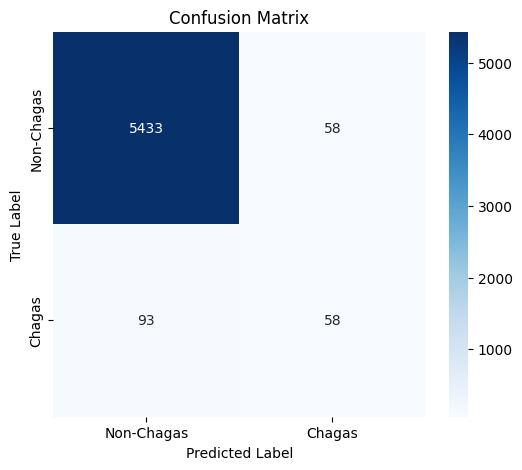

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ Confusion Matrix 계산
cm = confusion_matrix(y_test, meta_preds_test)

# ✅ Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Chagas", "Chagas"], yticklabels=["Non-Chagas", "Chagas"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ✅ 실제 라벨과 예측값 비교
accuracy_code15 = accuracy_score(y_code15, y_pred_code15)
f1_code15 = f1_score(y_code15, y_pred_code15)

print(f"Code15 데이터에서 MLP+CatBoost 모델 Accuracy: {accuracy_code15:.4f}")
print(f"Code15 데이터에서 MLP+CatBoost 모델 F1 Score: {f1_code15:.4f}")

# ✅ 상세 리포트 출력
print(classification_report(y_code15, y_pred_code15))

In [154]:
# 모델 저장
joblib.dump(meta_model, "catboost_mlp_stacking_model_3data.pkl")
print("Model 저장 완료!")

Model 저장 완료!


In [143]:
import numpy as np
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import joblib

# ✅ Optuna를 이용한 Base Model 최적화 함수 정의
def objective_catboost_1(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study_cat_1 = optuna.create_study(direction="maximize")
study_cat_1.optimize(objective_catboost_1, n_trials=30)
best_params_cat_1 = study_cat_1.best_params

# ✅ Base Model 2 (CatBoost) 최적화 - 조금 다른 파라미터 범위 설정
def objective_catboost_2(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'depth': trial.suggest_int('depth', 6, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 5),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.1, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study_cat_2 = optuna.create_study(direction="maximize")
study_cat_2.optimize(objective_catboost_2, n_trials=30)
best_params_cat_2 = study_cat_2.best_params

# ✅ Stratified K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# ✅ Base Model을 학습하면서 Fold마다 예측값 저장할 배열
train_meta_features = np.zeros((X_train.shape[0], 2))  # 두 개의 Base Model 사용
test_meta_features = np.zeros((X_test.shape[0], 2))

# ✅ Base Model 1 (CatBoost) 학습
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"🔹 Base Model 1 학습 중 - Fold {fold+1}/{n_splits}")

    X_tr, X_val = X_train[train_idx], X_train[valid_idx]
    y_tr, y_val = y_train[train_idx], y_train[valid_idx]

    model = CatBoostClassifier(**best_params_cat_1, verbose=0)
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    train_meta_features[valid_idx, 0] = model.predict_proba(X_val)[:, 1]  # 확률값 사용
    test_meta_features[:, 0] += model.predict_proba(X_test)[:, 1] / n_splits  # K-Fold 평균

# ✅ Base Model 2 (CatBoost) 학습
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"🔹 Base Model 2 학습 중 - Fold {fold+1}/{n_splits}")

    X_tr, X_val = X_train[train_idx], X_train[valid_idx]
    y_tr, y_val = y_train[train_idx], y_train[valid_idx]

    model = CatBoostClassifier(**best_params_cat_2, verbose=0)
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    train_meta_features[valid_idx, 1] = model.predict_proba(X_val)[:, 1]
    test_meta_features[:, 1] += model.predict_proba(X_test)[:, 1] / n_splits

[I 2025-03-01 18:56:52,429] A new study created in memory with name: no-name-89ff18d9-ea7c-4333-aad6-6da9ba235bb4
/tmp/ipykernel_930/1609939778.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_930/1609939778.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
/tmp/ipykernel_930/1609939778.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.sugges

🔹 Base Model 1 학습 중 - Fold 1/5
🔹 Base Model 1 학습 중 - Fold 2/5
🔹 Base Model 1 학습 중 - Fold 3/5
🔹 Base Model 1 학습 중 - Fold 4/5
🔹 Base Model 1 학습 중 - Fold 5/5
🔹 Base Model 2 학습 중 - Fold 1/5
🔹 Base Model 2 학습 중 - Fold 2/5
🔹 Base Model 2 학습 중 - Fold 3/5
🔹 Base Model 2 학습 중 - Fold 4/5
🔹 Base Model 2 학습 중 - Fold 5/5


In [150]:
# ✅ Meta Model 학습
meta_model = CatBoostClassifier(n_estimators=800, depth=6, learning_rate=0.05, verbose=0)
meta_model.fit(train_meta_features, y_train)

# ✅ 최종 예측
y_pred_stack = meta_model.predict(test_meta_features)

accuracy_stack = accuracy_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)

print(f"CatBoost Stacking with Cross Validation Accuracy: {accuracy_stack:.4f}")
print(f"CatBoost Stacking with Cross Validation F1 Score: {f1_stack:.4f}")

CatBoost Stacking with Cross Validation Accuracy: 0.9792
CatBoost Stacking with Cross Validation F1 Score: 0.6619


In [147]:
# ✅ 최적 모델 저장
joblib.dump(meta_model, "catboost_stacking_model3.pkl")
print("Model 저장 완료!")

Model 저장 완료!


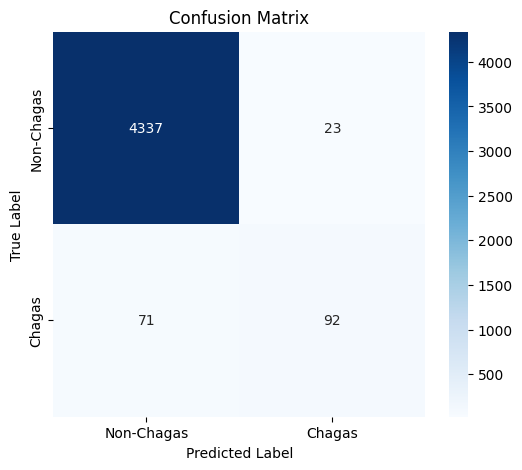

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred_stack)

# ✅ Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Chagas", "Chagas"], yticklabels=["Non-Chagas", "Chagas"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [149]:
from sklearn.metrics import classification_report

# ✅ 모델 성능 상세 분석
print("🔥 Classification Report 🔥")
print(classification_report(y_test, y_pred_stack))

🔥 Classification Report 🔥
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4360
           1       0.80      0.56      0.66       163

    accuracy                           0.98      4523
   macro avg       0.89      0.78      0.83      4523
weighted avg       0.98      0.98      0.98      4523



### Ensemble ver4. (deep Resnet + catboost)

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Add

# ✅ ResNet Block
def resnet_block(x, units, dropout_rate=0.3):
    shortcut = x  # Residual Connection

    x = Dense(units, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation="relu")(x)
    x = BatchNormalization()(x)
    
    # Residual Connection
    x = Add()([x, shortcut])
    return x

# ✅ ResNet 모델 생성
def build_resnet(input_dim):
    inputs = Input(shape=(input_dim,))
    
    x = Dense(128, activation="relu")(inputs)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation="sigmoid")(x)  
    
    model = Model(inputs, x)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ✅ ResNet 모델 학습
resnet_model = build_resnet(X_train.shape[1])
resnet_model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)

# ✅ 예측값 생성 (확률 값 사용)
resnet_train_preds = resnet_model.predict(X_train).flatten()
resnet_test_preds = resnet_model.predict(X_test).flatten()

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9445 - loss: 0.1905
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9700 - loss: 0.1187
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9708 - loss: 0.1102
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9692 - loss: 0.1137
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9713 - loss: 0.1058
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9684 - loss: 0.1091
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9687 - loss: 0.1058
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9689 - loss: 0.1042
Epoch 9/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9706 - loss: 0.0987
Epoch 10/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9707 - loss: 0.0995
Epoch 11/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9714 - loss: 0.0946
Epoch 12/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

In [49]:
# ✅ ResNet 모델 Accuracy 평가 (Keras 내장 evaluate 함수 사용)
resnet_accuracy = resnet_model.evaluate(X_test, y_test, verbose=0)[1]  # [0]: loss, [1]: accuracy
resnet_preds_test = (resnet_model.predict(X_test) > 0.5).astype(int)
resnet_f1 = f1_score(y_test, resnet_preds_test)

print(f"ResNet Model Accuracy: {resnet_accuracy:.4f}")
print(f"ResNet Model F1 Score: {resnet_f1:.4f}")


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
ResNet Model Accuracy: 0.9729
ResNet Model F1 Score: 0.1905


In [45]:
# Challenge score

from helper_code import compute_challenge_score  # helper_code에서 함수 가져오기

# ✅ ResNet 모델 확률 예측 (0~1 사이 값)
y_pred_prob = resnet_model.predict(X_test).flatten()  # ResNet은 predict()로 확률값 반환

# ✅ 실제 라벨
y_true = y_test  # 실제 정답 레이블 (0 또는 1)

# ✅ Challenge Score 계산
challenge_score = compute_challenge_score(y_true, y_pred_prob)

print(f"Challenge Score: {challenge_score:.3f}")

# Challenge Score: 0.388

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Challenge Score: 0.388


Stacking 해보기

In [33]:
from catboost import CatBoostClassifier

# ✅ CatBoost 모델 학습
catboost_model = CatBoostClassifier(n_estimators=1000, depth=6, learning_rate=0.05, verbose=0)
catboost_model.fit(X_train, y_train)

# ✅ 예측값 생성 (확률 값 사용)
catboost_train_preds = catboost_model.predict_proba(X_train)[:, 1]
catboost_test_preds = catboost_model.predict_proba(X_test)[:, 1]

In [34]:
import numpy as np

# Meta 모델을 위한 새로운 입력 데이터 생성
X_train_meta = np.column_stack((resnet_train_preds, catboost_train_preds))
X_test_meta = np.column_stack((resnet_test_preds, catboost_test_preds))

# Meta Model (CatBoost) 학습
meta_model = CatBoostClassifier(n_estimators=500, depth=6, learning_rate=0.05, verbose=0)
meta_model.fit(X_train_meta, y_train)

# Meta Model 예측
meta_preds_test = meta_model.predict(X_test_meta)


In [35]:
from sklearn.metrics import accuracy_score, f1_score

meta_acc = accuracy_score(y_test, meta_preds_test)
meta_f1 = f1_score(y_test, meta_preds_test)

print(f"✅ Meta Model Accuracy: {meta_acc:.4f}")
print(f"✅ Meta Model F1 Score: {meta_f1:.4f}")


✅ Meta Model Accuracy: 0.9601
✅ Meta Model F1 Score: 0.2947


In [36]:
# Challenge score

from helper_code import compute_challenge_score  # helper_code에서 함수 가져오기

# 모델 예측값 (확률 기반)
y_pred_prob = meta_model.predict_proba(X_test)[:, 1]  # 모델이 1(양성)일 확률 예측

# 실제 라벨
y_true = y_test  # 실제 정답 레이블 (0 또는 1)

# ✅ Challenge Score 계산
challenge_score = compute_challenge_score(y_true, y_pred_prob)

print(f"Challenge Score: {challenge_score:.3f}")

# Challenge Score: 0.159

Challenge Score: 0.159


RBBB 변수 추가

In [50]:
df

,qrs_width,qt_interval,rmssd,sdnn,sd1,sd2,sd_ratio,ulf,vlf,lf,...,wavelet_L3_mean,wavelet_L3_std,wavelet_L3_energy,wavelet_L3_energy_ratio,wavelet_L4_mean,wavelet_L4_std,wavelet_L4_energy,wavelet_L4_energy_ratio,wavelet_entropy,Chagas_label
0,0.703654,0.470000,0.174284,0.204487,0.118488,0.241682,0.490265,0.0,0.0,0.0,...,0.009941,0.024247,0.604989,0.000210,0.000588,0.001387,0.003945,0.000001,7.782457,0
1,0.884167,0.482143,0.046098,0.032745,0.032473,0.035979,0.902552,0.0,0.0,0.0,...,0.005254,0.009996,0.073746,0.001666,0.000360,0.000613,0.000552,0.000012,7.616258,0
2,0.742500,0.475938,0.005863,0.003273,0.004135,0.002585,1.599513,0.0,0.0,0.0,...,0.009528,0.019653,0.285036,0.000921,0.000658,0.001319,0.002557,0.000008,7.693137,0
3,0.763182,0.473333,0.188491,0.105481,0.133281,0.081842,1.628517,0.0,0.0,0.0,...,0.008234,0.020840,0.446886,0.000207,0.000520,0.001300,0.003467,0.000002,7.720231,0
4,1.191667,0.476071,0.048926,0.026127,0.034580,0.019125,1.808123,0.0,0.0,0.0,...,0.004214,0.011350,0.132568,0.000437,0.000252,0.000620,0.000790,0.000003,7.787702,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37608,0.732727,0.140833,0.008874,0.012082,0.006021,0.013597,0.442807,0.0,0.0,0.0,...,0.009821,0.038275,1.507493,0.020457,0.000735,0.002870,0.016892,0.000229,6.359781,0
37609,0.975313,0.452778,0.007440,0.005788,0.005163,0.006339,0.814550,0.0,0.0,0.0,...,0.003090,0.007840,0.063252,0.001969,0.000234,0.000585,0.000703,0.000022,7.698452,0
37610,1.035714,0.470625,0.042781,0.029085,0.030134,0.029833,1.010092,0.0,0.0,0.0,...,0.005421,0.014932,0.229416,0.002303,0.000381,0.001016,0.002118,0.000021,7.562485,0
37611,1.085714,0.143750,0.020207,0.014743,0.014093,0.016202,0.869835,0.0,0.0,0.0,...,0.007415,0.036437,1.366167,0.032008,0.000573,0.002871,0.016902,0.000396,5.754064,0
